In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install supervision
!nvidia-smi

import os
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.5 MB/s eta 0:00:00
Mon Sep 18 17:53:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import cv2
import supervision as sv
image_bgr = cv2.imread('/content/Screenshot 2023-09-19 000610.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(10,10),
    size=(100,100)
)

In [39]:
from PIL import Image
for i in range(len(masks)):
    im = Image.fromarray(masks[i])
    im.save("/content/Masks"+str(i)+".jpeg")


In [6]:
#mask_predictor = SamPredictor(sam)

import os

IMAGE_PATH = '/content/drive/MyDrive/SIH 2023-20230906T201653Z-001/SIH 2023 test dataset/1693902199154.jpg'

In [7]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [4]:
!pip install jupyter-bbox-widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00


In [8]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [9]:
widget.bboxes

[{'x': 493, 'y': 337, 'width': 657, 'height': 719, 'label': ''}]

In [10]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [11]:
box

array([ 493,  337, 1150, 1056])

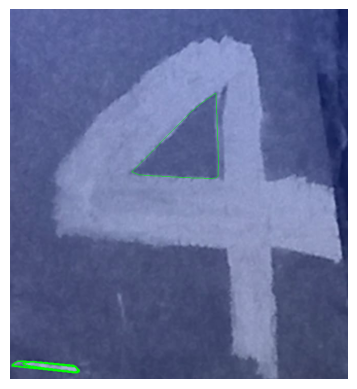

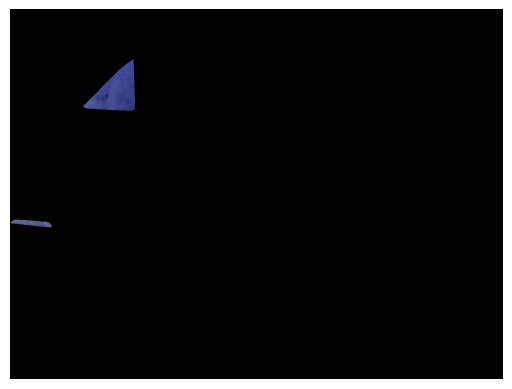

In [14]:
# Import packages
import cv2
import numpy as np
#import supervision as sv
import matplotlib.pyplot as plt

#Create MSER object
mser = cv2.MSER_create()

#Your image path i-e receipt path
img = cv2.imread('/content/drive/MyDrive/SIH 2023-20230906T201653Z-001/SIH 2023 test dataset/1693902199154.jpg')
#img = train_data[14]
cropped_image = img[box[1]:box[3], box[0]:box[2]]
#Convert to gray scale
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

vis = cropped_image.copy()

#detect regions in gray scale image
regions, _ = mser.detectRegions(gray)

hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

cv2.polylines(vis, hulls, 1, (0, 255, 0))

plt.imshow(vis)
plt.axis('off')
plt.show()

mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)

for contour in hulls:

    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

#this is used to find only text regions, remaining are ignored
text_only = cv2.bitwise_and(img, img, mask=mask)

plt.imshow(text_only)
plt.axis('off')
plt.show()

In [17]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

KeyboardInterrupt: ignored

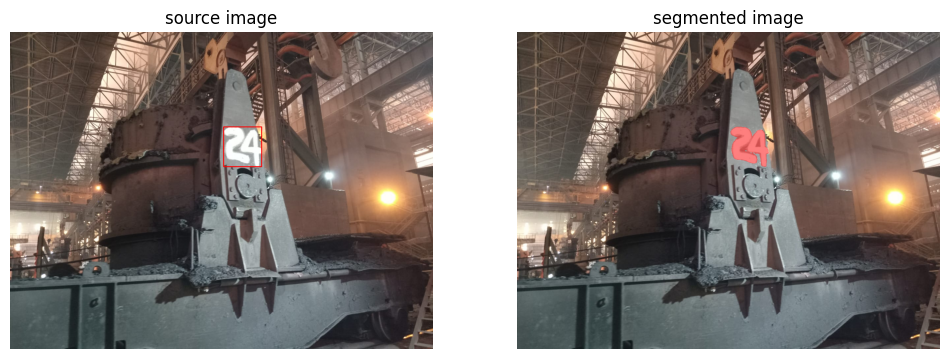

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

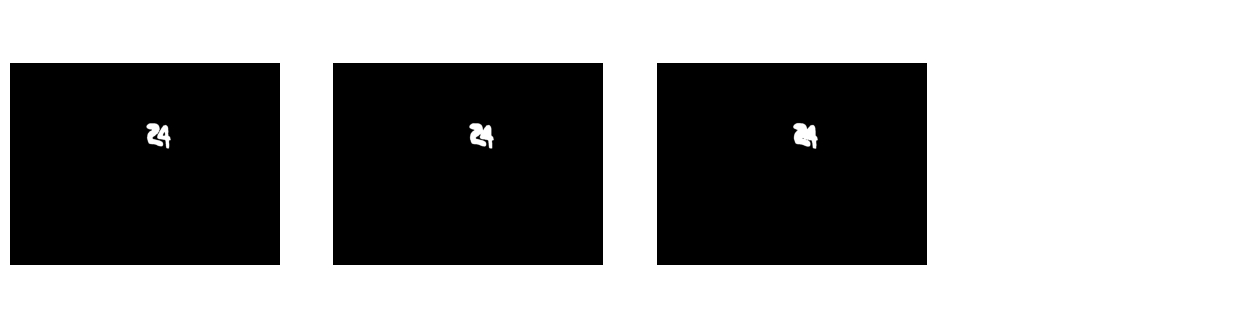

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)